In [ ]:
%pip install missingno

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from IPython.core.interactiveshell import InteractiveShell
from scipy import stats
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
# display scientific notation as a float
pd.set_option("display.float_format", lambda x: "%.3f" % x)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="white", rc=custom_params, palette="Set2")

encodings = {}


In [ ]:
import data_cleaning_lib as lib


# Part 0: Data Exploration

In [ ]:
filename = "./src/Medical Data/medical_raw_data.csv"
df = pd.read_csv(filename)


In [ ]:
df.dtypes
print(df.shape, end="\n\n")
print(df.columns, end="\n\n")
print(df.index, end="\n\n")
df.info()


In [ ]:
df.head()


In [ ]:
df.describe()


### Missing Values

In [ ]:
(df.isna().sum() / len(df) * 100).sort_values(ascending=False)


# Part I: Research Question
---

## A. Question or Decision

**Describe one question or decision that you will address using the data set you chose. The summarized question or decision must be relevant to a realistic organizational need or situation.**

To understand where to focus readmission reduction efforts for the Acme Hospital Chain. The Analyst team is tasked with researching what relationship(s) exists between readmitted patients and their Geographical Area type (rural, urban, suburban)?

## B. Required Variables
Describe the variables in the data set and indicate the specific type of data being described. Use examples from the data set that support your claims.**

In [67]:
# merges datatypes with sample data
# see "D206 Data Cleaning_ Medical Data Considerations and Dictionary" for feature descriptions
df_tp = df.head(1).transpose()

# store the value's python data type
df_tp["Python Data Type"] = df_tp[0].apply(type)

# store the value's pandas data type
df_tp["Pandas Data Type"] = df.dtypes

# rename cols
df_tp = df_tp.reset_index().rename(columns={"index": "Feature", 0: "Sample Value"})

# reorder columns
df_tp.reindex(
    columns=["Feature", "Pandas Data Type", "Python Data Type", "Sample Value"]
)


,Feature,Pandas Data Type,Python Data Type,Sample Value
0,Unnamed: 0,int64,<class 'int'>,1
1,CaseOrder,int64,<class 'int'>,1
2,Customer_id,object,<class 'str'>,C412403
3,Interaction,object,<class 'str'>,8cd49b13-f45a-4b47-a2bd-173ffa932c2f
4,UID,object,<class 'str'>,3a83ddb66e2ae73798bdf1d705dc0932
5,City,object,<class 'str'>,Eva
6,State,object,<class 'str'>,AL
7,County,object,<class 'str'>,Morgan
8,Zip,int64,<class 'int'>,35621
9,Lat,float64,<class 'float'>,34.350


# Part II: Data-Cleaning Plan
---

Explain the plan for cleaning the data by doing the following:
 1. Examine the entire dataset (regardless of your research question).
 2. Detection and Treatment of Duplicates, Missing Values and Outlier (check for outliers for all numeric variables).
 3. Re express Categorical Variables, if possible (this is optional, but suggested)
 4. Perform PCA (with numerical variables only)

## C1: Plan to Find Anomalies
Propose a plan that includes the relevant techniques and specific steps needed to identify anomalies in the data set.

### Understanding the dataset

In [68]:
df.shape
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 53 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Unnamed: 0          10000 non-null  int64   
 1   CaseOrder           10000 non-null  int64   
 2   Customer_id         10000 non-null  object  
 3   Interaction         10000 non-null  object  
 4   UID                 10000 non-null  object  
 5   City                10000 non-null  object  
 6   State               10000 non-null  object  
 7   County              10000 non-null  object  
 8   Zip                 10000 non-null  int64   
 9   Lat                 10000 non-null  float64 
 10  Lng                 10000 non-null  float64 
 11  Population          10000 non-null  int64   
 12  Area                10000 non-null  category
 13  Timezone            10000 non-null  category
 14  Job                 10000 non-null  object  
 15  Children            7412 non-null   f

In [69]:
display(df.columns)
display(df.describe())
df.head()


Index(['Unnamed: 0', 'CaseOrder', 'Customer_id', 'Interaction', 'UID', 'City',
       'State', 'County', 'Zip', 'Lat', 'Lng', 'Population', 'Area',
       'Timezone', 'Job', 'Children', 'Age', 'Education', 'Employment',
       'Income', 'Marital', 'Gender', 'ReAdmis', 'VitD_levels', 'Doc_visits',
       'Full_meals_eaten', 'VitD_supp', 'Soft_drink', 'Initial_admin',
       'HighBlood', 'Stroke', 'Complication_risk', 'Overweight', 'Arthritis',
       'Diabetes', 'Hyperlipidemia', 'BackPain', 'Anxiety',
       'Allergic_rhinitis', 'Reflux_esophagitis', 'Asthma', 'Services',
       'Initial_days', 'TotalCharge', 'Additional_charges', 'Item1', 'Item2',
       'Item3', 'Item4', 'Item5', 'Item6', 'Item7', 'Item8'],
      dtype='object')

,Unnamed: 0,CaseOrder,Zip,Lat,Lng,Population,Children,Age,Income,VitD_levels,Doc_visits,Full_meals_eaten,VitD_supp,Anxiety,Initial_days,TotalCharge,Additional_charges,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,7412.000,7586.000,7536.000,10000.000,10000.000,10000.000,10000.000,9016.000,8944.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,5000.500,5000.500,50159.324,38.751,-91.243,9965.254,2.098,53.296,40484.438,19.413,5.012,1.001,0.399,0.322,34.432,5891.538,12934.529,3.519,3.507,3.511,3.515,3.497,3.522,3.494,3.510
std,2886.896,2886.896,27469.588,5.403,15.206,14824.759,2.155,20.659,28664.861,6.723,1.046,1.008,0.629,0.467,26.287,3377.558,6542.602,1.032,1.035,1.033,1.036,1.030,1.032,1.021,1.042
min,1.000,1.000,610.000,17.967,-174.210,0.000,0.000,18.000,154.080,9.519,1.000,0.000,0.000,0.000,1.002,1256.752,3125.703,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
25%,2500.750,2500.750,27592.000,35.255,-97.353,694.750,0.000,35.000,19450.792,16.513,4.000,0.000,0.000,0.000,7.912,3253.239,7986.488,3.000,3.000,3.000,3.000,3.000,3.000,3.000,3.000
50%,5000.500,5000.500,50207.000,39.419,-88.397,2769.000,1.000,53.000,33942.280,18.081,5.000,1.000,0.000,0.000,34.447,5852.251,11573.979,4.000,3.000,4.000,4.000,3.000,4.000,3.000,3.000
75%,7500.250,7500.250,72411.750,42.044,-80.438,13945.000,3.000,71.000,54075.235,19.790,6.000,2.000,1.000,1.000,61.125,7614.990,15626.491,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000
max,10000.000,10000.000,99929.000,70.561,-65.290,122814.000,10.000,89.000,207249.130,53.019,9.000,7.000,5.000,1.000,71.981,21524.224,30566.073,8.000,7.000,8.000,7.000,7.000,7.000,7.000,7.000


,Unnamed: 0,CaseOrder,Customer_id,Interaction,UID,City,State,County,Zip,Lat,Lng,Population,Area,Timezone,Job,Children,Age,Education,Employment,Income,Marital,Gender,ReAdmis,VitD_levels,Doc_visits,Full_meals_eaten,VitD_supp,Soft_drink,Initial_admin,HighBlood,Stroke,Complication_risk,Overweight,Arthritis,Diabetes,Hyperlipidemia,BackPain,Anxiety,Allergic_rhinitis,Reflux_esophagitis,Asthma,Services,Initial_days,TotalCharge,Additional_charges,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8
0,1,1,C412403,8cd49b13-f45a-4b47-a2bd-173ffa932c2f,3a83ddb66e2ae73798bdf1d705dc0932,Eva,AL,Morgan,35621,34.350,-86.725,2951,Suburban,America/Chicago,"Psychologist, sport and exercise",1.000,53.000,"Some College, Less than 1 Year",Full Time,86575.930,Divorced,Male,No,17.802,6,0,0,No,Emergency Admission,Yes,No,Medium,No,Yes,Yes,No,Yes,1.000,Yes,No,Yes,Blood Work,10.586,3191.049,17939.403,3,3,2,2,4,3,3,4
1,2,2,Z919181,d2450b70-0337-4406-bdbb-bc1037f1734c,176354c5eef714957d486009feabf195,Marianna,FL,Jackson,32446,30.845,-85.229,11303,Urban,America/Chicago,Community development worker,3.000,51.000,"Some College, 1 or More Years, No Degree",Full Time,46805.990,Married,Female,No,18.995,4,2,1,No,Emergency Admission,Yes,No,High,Yes,No,No,No,No,NaN,No,Yes,No,Intravenous,15.130,4214.905,17612.998,3,4,3,4,4,4,3,3
2,3,3,F995323,a2057123-abf5-4a2c-abad-8ffe33512562,e19a0fa00aeda885b8a436757e889bc9,Sioux Falls,SD,Minnehaha,57110,43.543,-96.638,17125,Suburban,America/Chicago,Chief Executive Officer,3.000,53.000,"Some College, 1 or More Years, No Degree",Retired,14370.140,Widowed,Female,No,17.416,4,1,0,No,Elective Admission,Yes,No,Medium,Yes,No,Yes,No,No,NaN,No,No,No,Blood Work,4.772,2177.587,17505.192,2,4,4,4,3,4,3,3
3,4,4,A879973,1dec528d-eb34-4079-adce-0d7a40e82205,cd17d7b6d152cb6f23957346d11c3f07,New Richland,MN,Waseca,56072,43.897,-93.515,2162,Suburban,America/Chicago,Early years teacher,0.000,78.000,GED or Alternative Credential,Retired,39741.490,Married,Male,No,17.420,4,1,0,No,Elective Admission,No,Yes,Medium,No,Yes,No,No,No,NaN,No,Yes,Yes,Blood Work,1.715,2465.119,12993.437,3,5,5,3,4,5,5,5
4,5,5,C544523,5885f56b-d6da-43a3-8760-83583af94266,d2f0425877b10ed6bb381f3e2579424a,West Point,VA,King William,23181,37.599,-76.890,5287,Rural,America/New_York,Health promotion specialist,NaN,22.000,Regular High School Diploma,Full Time,1209.560,Widowed,Female,No,16.871,5,0,2,Yes,Elective Admission,No,No,Low,No,No,No,Yes,No,0.000,Yes,No,No,CT Scan,1.255,1885.655,3716.526,2,1,3,3,5,3,4,3


In [ ]:
pd.DataFrame(df.isnull().sum().sort_values(ascending=False))


### Detect Duplicates

In [70]:
df[df.duplicated()]


,Unnamed: 0,CaseOrder,Customer_id,Interaction,UID,City,State,County,Zip,Lat,Lng,Population,Area,Timezone,Job,Children,Age,Education,Employment,Income,Marital,Gender,ReAdmis,VitD_levels,Doc_visits,Full_meals_eaten,VitD_supp,Soft_drink,Initial_admin,HighBlood,Stroke,Complication_risk,Overweight,Arthritis,Diabetes,Hyperlipidemia,BackPain,Anxiety,Allergic_rhinitis,Reflux_esophagitis,Asthma,Services,Initial_days,TotalCharge,Additional_charges,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8


In [71]:
df[df.duplicated(subset=["Customer_id", "Interaction", "UID"])]


,Unnamed: 0,CaseOrder,Customer_id,Interaction,UID,City,State,County,Zip,Lat,Lng,Population,Area,Timezone,Job,Children,Age,Education,Employment,Income,Marital,Gender,ReAdmis,VitD_levels,Doc_visits,Full_meals_eaten,VitD_supp,Soft_drink,Initial_admin,HighBlood,Stroke,Complication_risk,Overweight,Arthritis,Diabetes,Hyperlipidemia,BackPain,Anxiety,Allergic_rhinitis,Reflux_esophagitis,Asthma,Services,Initial_days,TotalCharge,Additional_charges,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8


In [72]:
# determine if 'Unnamed: 0' and 'CaseOrder' columns have the same values
(df["Unnamed: 0"] == df["CaseOrder"]).all()


True

### Detect Missing Values

In [73]:
# get column names for any columns with missing values
missing_cols = df.columns[df.isnull().any()]

# create a dataframe of columns with missing values
missing_df = df[missing_cols]
pct_missing_df = pd.DataFrame()

# calculate % missing for columns with missing data
pct_missing_df["missing cnt"] = missing_df.isnull().sum()
pct_missing_df["missing %"] = (pct_missing_df["missing cnt"] / len(df.index)) * 100

# sort % missing in descending order
pct_missing_df.sort_values(by="missing cnt", ascending=False, axis=0)


,missing cnt,missing %
Children,2588,25.880
Income,2464,24.640
Age,2414,24.140
Initial_days,1056,10.560
Anxiety,984,9.840


#### Missing Matrix

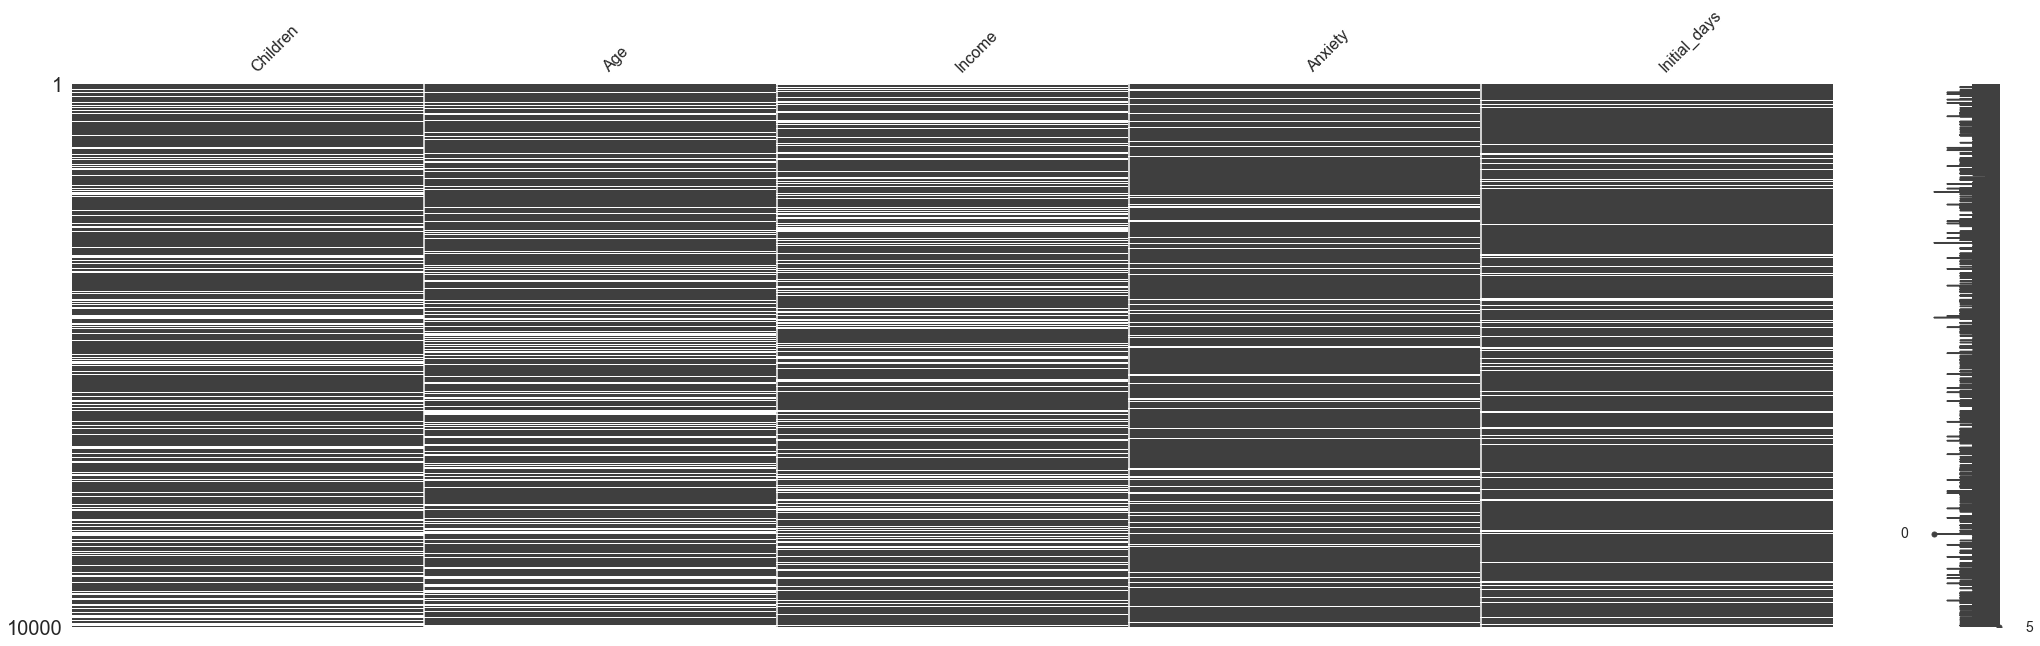

In [74]:
# visualize the dataframe's nullity
_ = msno.matrix(missing_df, figsize=(35, 10))


#### Missing Bar Chart

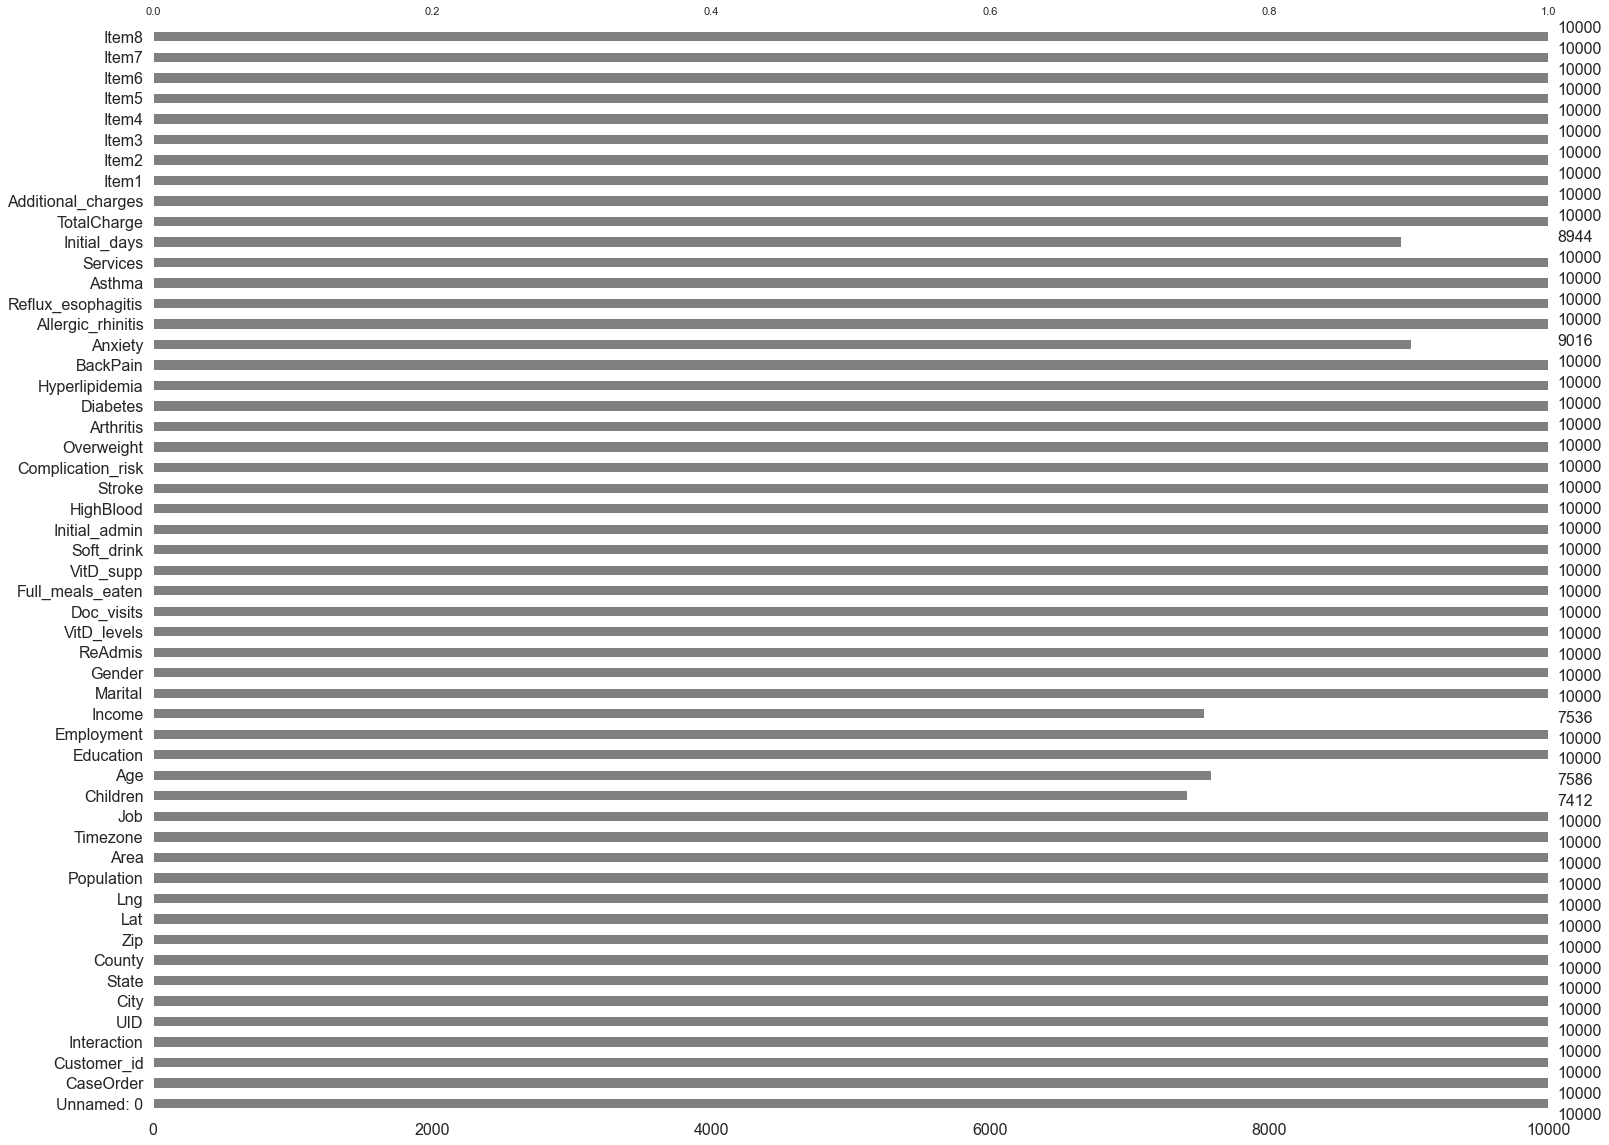

In [75]:
# bar chart visualization of the dataframe's nullity
_ = msno.bar(df, figsize=(25, 20), color="gray")


#### Missing Heatmap

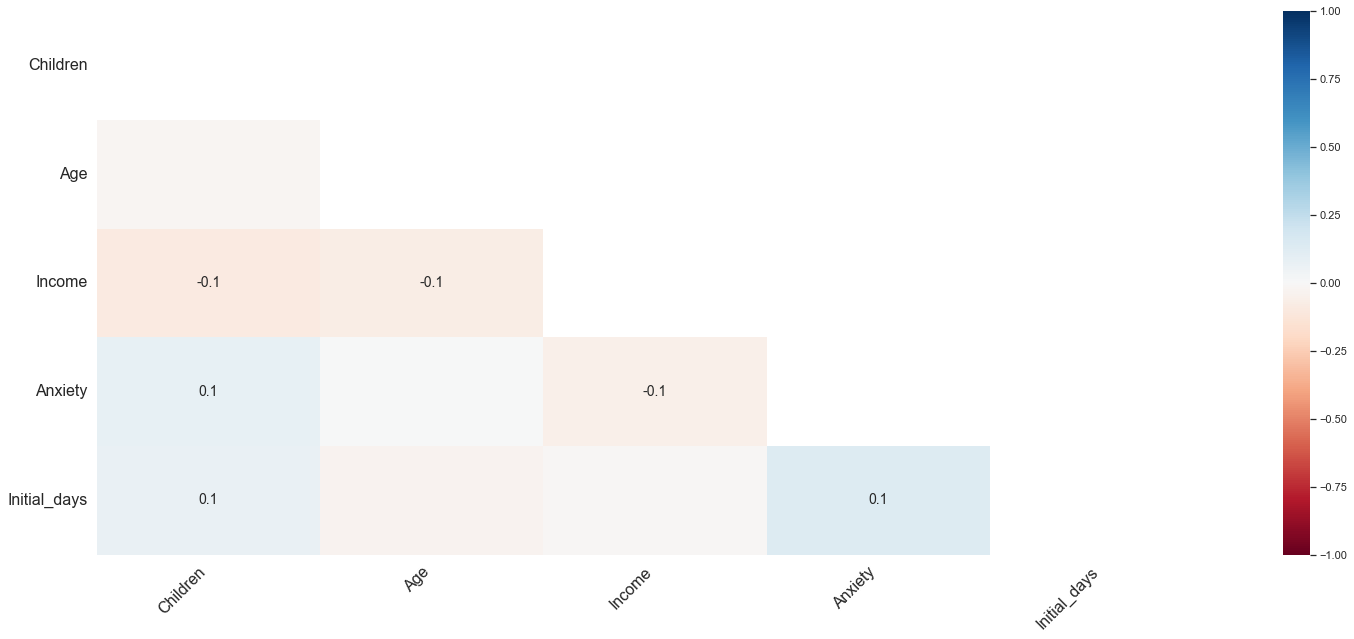

In [76]:
# heatmap visualization of nullity correlation within the DataFrame (displaying 250 records).
# -1 indicates if one variable appears then the other variable is very likely to be missing.
# 0 indicates there is no dependence between the occurrence of missing values of two variables.
# 1 indicates that when one variable appears then the other variable is likely to be present.
_ = msno.heatmap(missing_df.loc[:250], figsize=(25, 10))


#### Missing Dendrogram

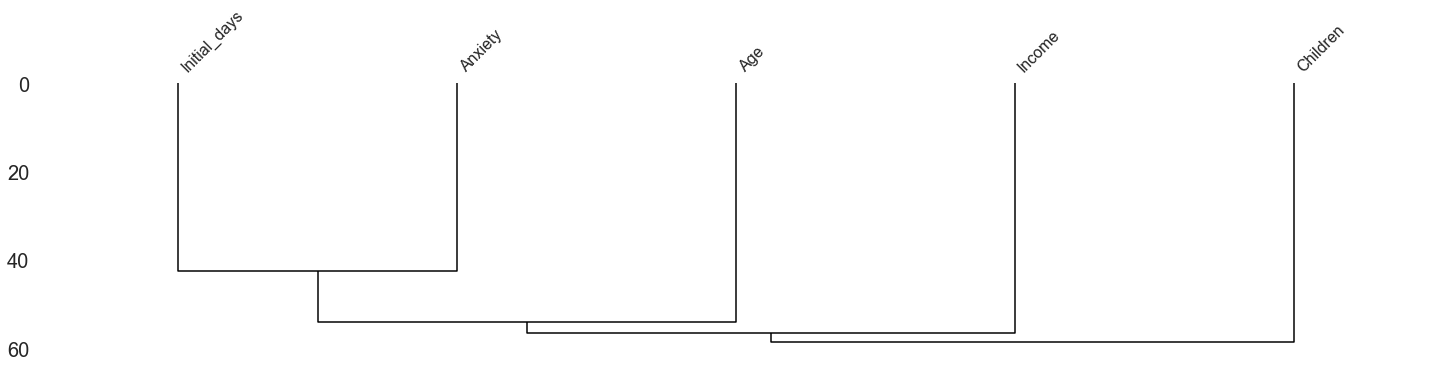

In [77]:
# shows the hierarchical relationship between objects
_ = msno.dendrogram(missing_df, orientation="bottom", figsize=(25, 5))


### Detect Outliers

#### Z-Scores
find columns with addressable outliers

In [78]:
def get_zscore_cols(df):
    numeric_df = df.select_dtypes(include=["int64", "float64"]).apply(pd.to_numeric)
    z_score_df = np.abs(stats.zscore(numeric_df, nan_policy="omit")) > 3

    col_outlier_counts = z_score_df.sum()
    # create a dataframe using columns with at least 1 outlier
    outlier_counts_df = col_outlier_counts[col_outlier_counts > 0]

    # outlier column names
    return outlier_counts_df.index


# numerical columns with notable outliers that we're choosing to ignore
ignored_outlier_cols = [
    "Lat",
    "Lng",
    "Population",
    "Age",
    "Income",
    "TotalCharge",
    "Additional_charges",
    "Doc_visits",
]

# store the relevant zscore columns that are important to address
z_score_cols = list(set(get_zscore_cols(df)) - set(ignored_outlier_cols))
# columns
z_score_cols


['Item4',
 'Children',
 'Item3',
 'Item5',
 'Full_meals_eaten',
 'Item6',
 'VitD_levels',
 'Item1',
 'Item2',
 'Item7',
 'VitD_supp',
 'Item8']

#### store z-score values for addressable columns

In [79]:
zscore_df = df[z_score_cols].copy()

for col in z_score_cols:
    zscore_df[f"{col}_zscore"] = stats.zscore(df[col], nan_policy="omit")
    # store values where their absolute values exceeds a z-score of > 3
    zscore_df.loc[abs(zscore_df[f"{col}_zscore"]) > 3, [col, f"{col}_zscore"]]

# display zscore values
zscore_df.iloc[:, zscore_df.columns.str.contains("zscore")]


,Item4_zscore,Children_zscore,Item3_zscore,Item5_zscore,Full_meals_eaten_zscore,Item6_zscore,VitD_levels_zscore,Item1_zscore,Item2_zscore,Item7_zscore,VitD_supp_zscore,Item8_zscore
0,-1.462,-0.510,-1.463,0.488,-0.993,-0.506,-0.240,-0.503,-0.490,-0.484,-0.635,0.470
1,0.468,0.418,-0.495,0.488,0.991,0.463,-0.062,-0.503,0.477,-0.484,0.956,-0.489
2,0.468,0.418,0.473,-0.482,-0.001,0.463,-0.297,-1.472,0.477,-0.484,-0.635,-0.489
3,-0.497,-0.974,1.442,0.488,-0.001,1.431,-0.296,-0.503,1.443,1.475,-0.635,1.430
4,-0.497,NaN,-0.495,1.459,-0.993,-0.506,-0.378,-1.472,-2.422,0.495,2.548,-0.489
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.497,NaN,-1.463,0.488,0.991,-0.506,-0.436,-0.503,-1.456,0.495,0.956,-1.448
9996,-1.462,0.882,0.473,1.459,-0.993,-0.506,-0.143,-0.503,-0.490,0.495,-0.635,0.470
9997,0.468,0.418,-0.495,0.488,0.991,-1.475,-0.544,-0.503,-0.490,-0.484,-0.635,-1.448
9998,0.468,0.418,-0.495,0.488,0.991,-0.506,0.378,1.435,1.443,0.495,0.956,-0.489


#### Boxplots

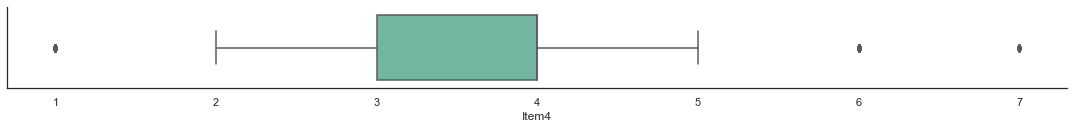

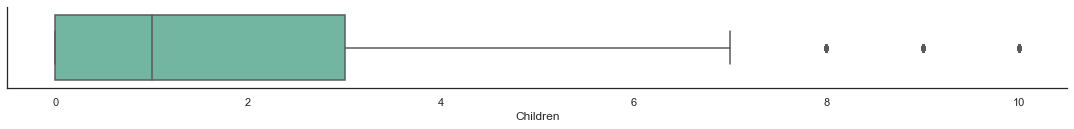

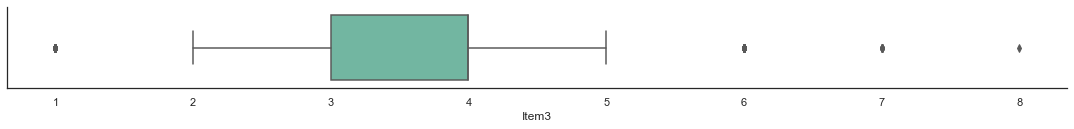

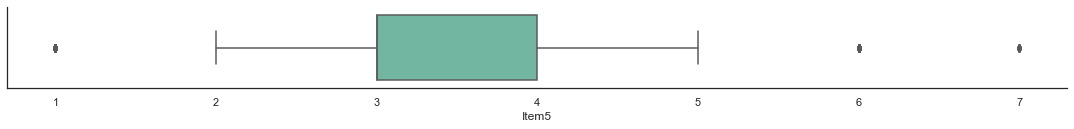

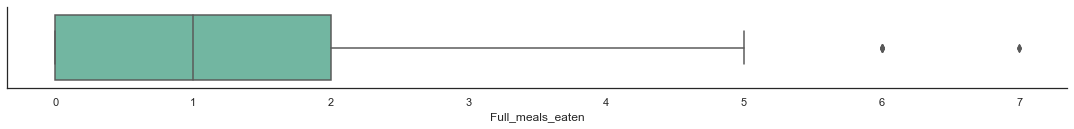

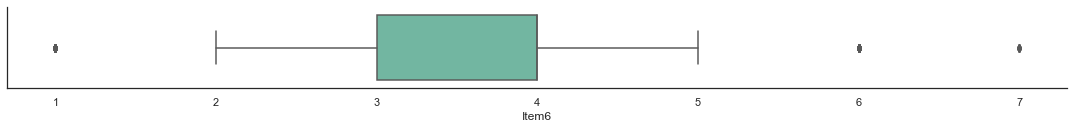

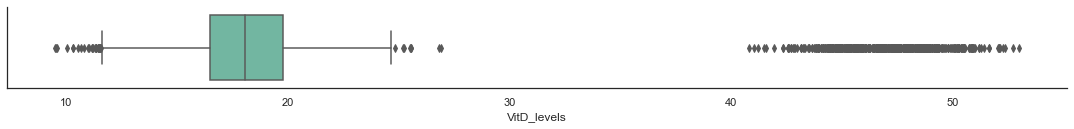

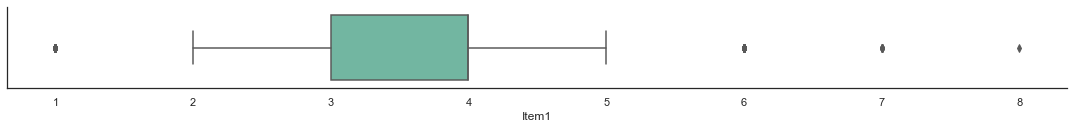

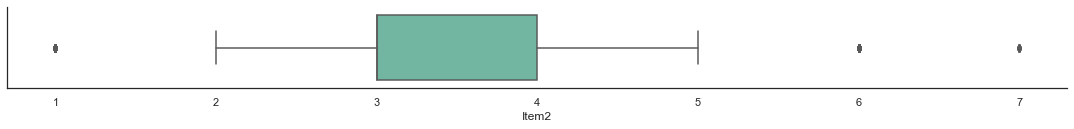

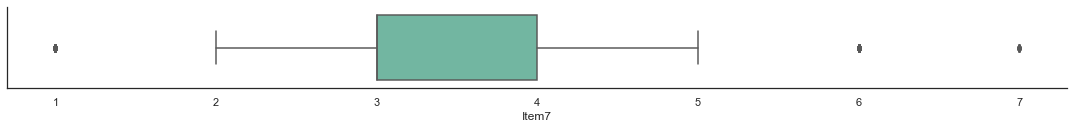

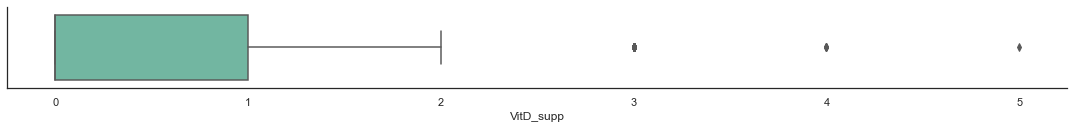

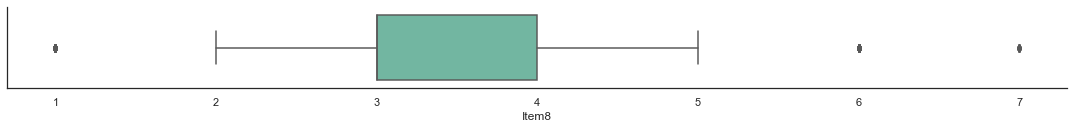

In [80]:
# lib.create_boxplots(df.loc[:, ~df.columns.isin(['Unnamed: 0', 'CaseOrder'])])

# display boxplots with known and relevant outliers
lib.create_boxplots(df[z_score_cols])


#### Histograms

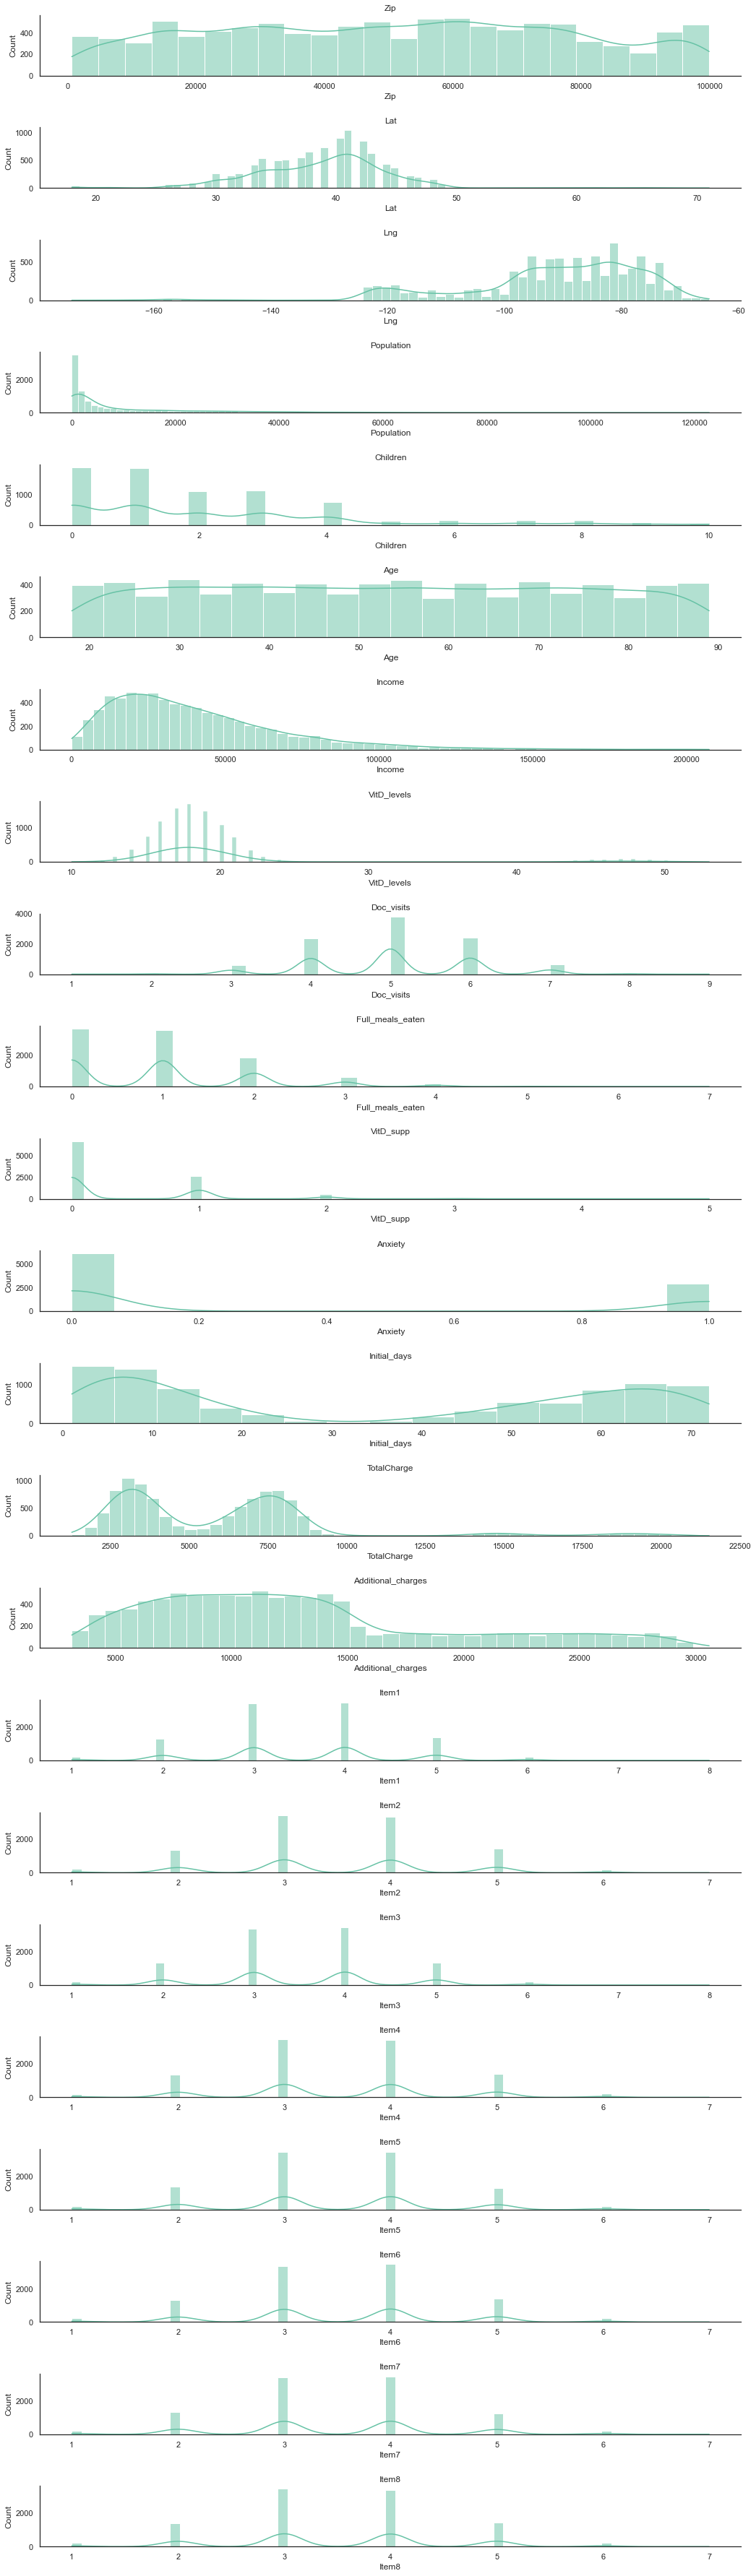

In [81]:
lib.create_histograms(df.loc[:, ~df.columns.isin(["Unnamed: 0", "CaseOrder"])])


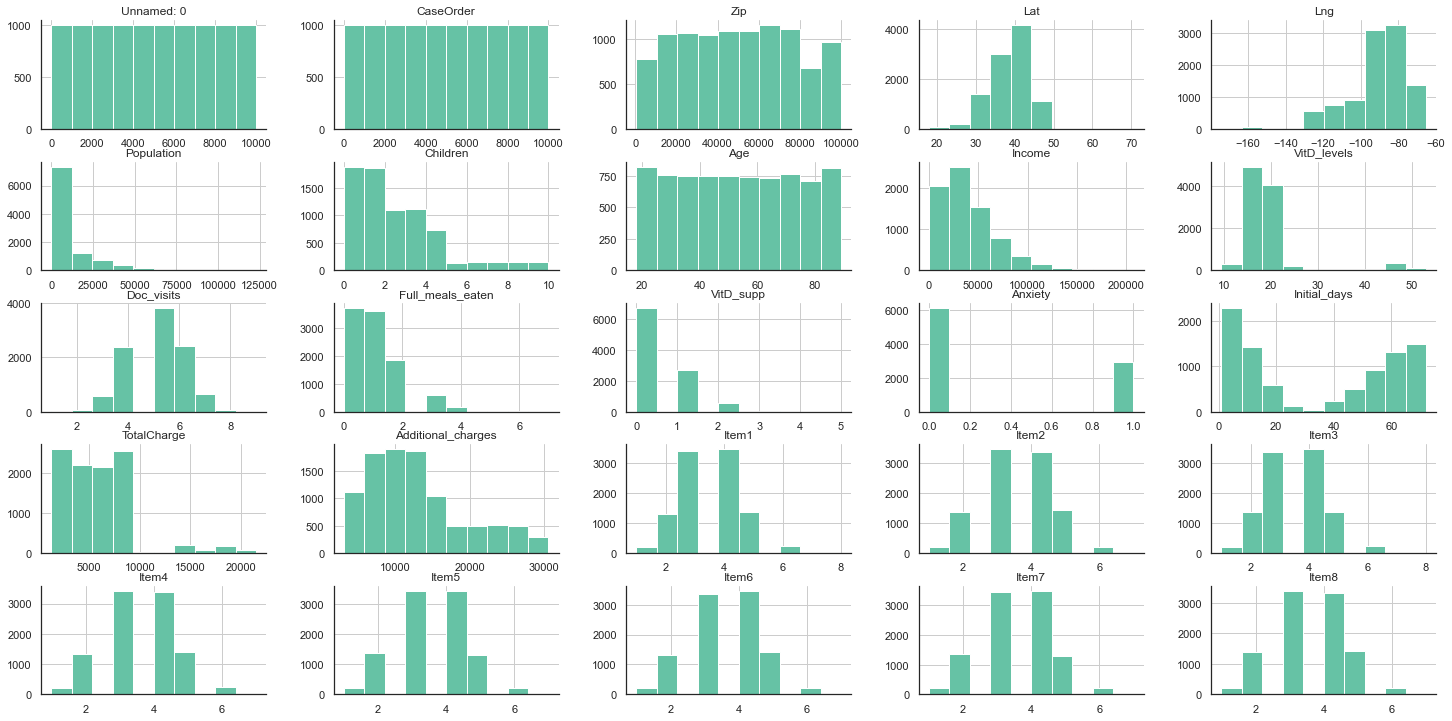

In [82]:
_ = df.hist(layout=(6, 5), figsize=(25, 15))


### Re-Expression Categories
convert categorical string values to category data type

In [83]:
# convert "Soft_drink" nan's to 'No'
df.loc[df["Soft_drink"].isna(), "Soft_drink"] = "No"

# convert "Overweight" float64's to Yes/No bools
df["Overweight"] = df["Overweight"].map({np.nan: "No", 0: "No", 1: "Yes"})

# validate a soft drink value exists for each record
assert len(df["Soft_drink"].isna().index) == len(df.index)

# categorical columns and potential categorical columns
ctg_cols = [
    "Allergic_rhinitis",
    "Area",
    "Arthritis",
    "Asthma",
    "BackPain",
    "Complication_risk",
    "Diabetes",
    "Education",
    "Employment",
    "Gender",
    "HighBlood",
    "Hyperlipidemia",
    "Initial_admin",
    "Marital",
    "Overweight",
    "ReAdmis",
    "Reflux_esophagitis",
    "Services",
    "Soft_drink",
    "Stroke",
    "Timezone",
]

for col in ctg_cols:
    # print(df[col].unique())
    print(f"--- CONVERTING COLUMN: '{col}' to category ---")

    # convert column to a category
    df = df.astype({col: "category"})

    # confirm the values successfully converted
    assert df[col].dtype == "category"

    # report categorical counts
    print(df[col].value_counts(), end="\n\n")


--- CONVERTING COLUMN: 'Allergic_rhinitis' to category ---
No     6059
Yes    3941
Name: Allergic_rhinitis, dtype: int64

--- CONVERTING COLUMN: 'Area' to category ---
Rural       3369
Suburban    3328
Urban       3303
Name: Area, dtype: int64

--- CONVERTING COLUMN: 'Arthritis' to category ---
No     6426
Yes    3574
Name: Arthritis, dtype: int64

--- CONVERTING COLUMN: 'Asthma' to category ---
No     7107
Yes    2893
Name: Asthma, dtype: int64

--- CONVERTING COLUMN: 'BackPain' to category ---
No     5886
Yes    4114
Name: BackPain, dtype: int64

--- CONVERTING COLUMN: 'Complication_risk' to category ---
Medium    4517
High      3358
Low       2125
Name: Complication_risk, dtype: int64

--- CONVERTING COLUMN: 'Diabetes' to category ---
No     7262
Yes    2738
Name: Diabetes, dtype: int64

--- CONVERTING COLUMN: 'Education' to category ---
Regular High School Diploma                 2444
Bachelor's Degree                           1724
Some College, 1 or More Years, No Degree    1484


### Cleaning text data



In [84]:
str_cols = df.select_dtypes("object")
df[str_cols.columns] = str_cols.apply(lambda s: s.str.strip())

# validate all state abbreviations are 2 characters
assert (df["State"].str.len() == 2).all()

# validate zip codes are 3, 4 or 5 digits
assert df["Zip"].astype("str").str.len().between(3, 5).all()

# cross field validation: validate 3 digit zip codes are Puerto Rican addresses
assert (
    df.loc[df["Zip"].astype("str").str.len() == 3, ["State", "Zip"]]["State"] == "PR"
).all()

# Customer_id, Interaction, UID, State,  and Zip

# validate all Customer_id values are 6 or 7 characters
pd.DataFrame(df["Customer_id"].str.len()).value_counts()
assert df["Customer_id"].str.len().between(6, 7).all()

# validate all Interaction values are 36 characters
pd.DataFrame(df["Interaction"].str.len()).value_counts()
assert (df["Interaction"].str.len() == 36).all()

# validate all Interaction values are 32 characters
pd.DataFrame(df["UID"].str.len()).value_counts()
assert (df["UID"].str.len() == 32).all()


### Other Data Cleaning

In [85]:
# Verify these columns are the same, if so drop the "Unnamed: 0" column
# drop "Unnamed: 0" if dupes
try:
    assert df["Unnamed: 0"].ne(df["CaseOrder"]).all()
except AssertionError:
    print("these are duplicate columns")


these are duplicate columns


In [86]:
# cast to int if this fails
try:
    assert df["Age"].dtype == "int"
except AssertionError:
    print("this column should be cast to an int")


this column should be cast to an int


In [87]:
# cast to int if this fails
try:
    assert df["Children"].dtype == "int"
except AssertionError:
    print("this column should be cast to an int")


this column should be cast to an int


## C2: Justification of Approach

## C3: Justification of Tools